# ONIOM
## A use case for a water absorption problem

## Table of contents:
* [1. Introduction](#1)
* [2. Use case - water absorption](#2)
* [3. Closing words](#3)


## 1. Introduction <a class="anchor" id="1"></a>
This notebook is intended to provide an overview of our implementation of the ONIOM method ([Chem. Rev. 2015, 115, 12, 5678–5796](https://pubs.acs.org/doi/10.1021/cr5004419)), a hybrid QM/MM technique. The ONIOM method enables the user to leverage the precision of expensive computational chemistry tools, only where expressly necessary. 

When studying large molecules, and their interactions with other systems, use of expensive computational techniques is often not only intractable, but also unnecessary. For example, when considering the interaction between a water molecule and a functional group appended to a large graphite flake, it is not reasonable to attempt to treat this entire problem at the level of something like Full Configuration Interaction (FCI) or Coupled Cluster methods (ex: CCSD(T)). In such situations, the ONIOM method enables us to target the fragments of the problem at hand with the most sophisticated techniques we can afford, while relegating the rest of the problem to the domain of more affordable computational methods. This method can become particularly advantageous when we are interested in energy differences, where the contribution to the total molecular energy from our relatively inert volumes become negligible. 

Formally, the energy evaluated by ONIOM is expressed as:

\begin{equation}
E_{ONIOM} = E_{ALL}^{LOW} + \sum_{i=1}^N (E_{FRAGMENT\ i}^{HIGH} - E_{FRAGMENT\ i}^{LOW})
\end{equation}

Where $E_{ALL}$, $E_{FRAGMENT}$, $LOW$ and $HIGH$ are respectively the energy of the whole system, the energy of a fragment and labels for a low and high precision methods. The general procedure for ONIOM is as follows. The user identifies a system of interest. A low-cost method is used to compute the total energy of the system. Subsequently, a subset of the molecule is defined as a model fragment. The fragment is isolated and an atom (or a functional group) is added to keep the valence fully populated. Its energy is computed using both the low-cost method as above and a high-cost method which can be applied on this reduced system. The difference in energy between these two models is then added to our total energy. In this way, we can interpret the ONIOM method as an iterative procedure where the error associated with our low-cost solver is removed.

The equation above is formulated to allow us to expand ONIOM beyond a single fragment -- in principle, many such fragments can be defined to progressively improve upon our result. This may apply to the situation where we have more than one active site on our large molecule, or where an incremental strategy can be utilized to further mitigate against errors associated with using our low-cost method in the vicinity of our active region. Moreover, this procedure can also be expanded to many precision layers. For example, one could define three precision for the calculation: $LOW$, $MEDIUM$ and $HIGH$.

## 2. Use case - water absorption<a class="anchor" id="2"></a>

### Why use ONIOM?

During a computational study, one can decide to scale up the system size for extanding the possible outcomes of the simulations. For example, in the water absorption study, a single molecule can be positionned near a chemical group to identify the interaction force and optimal distance between an hydrogen atom and a heteroatom with a negative partial charge. Scaling up in this case can mean adding more water molecules, thus disabling the hydrogen bond by stabilizing the relevant water molecule.

Even if the system size is very far from the thermodynamic limit, computational resources are still a constrain. Therefore, using a problem decomposition procedure can enable those simulations. With the help of ONIOM, one can target a specific interaction to compute with a high accuracy method while considering an environment with a lighter electronic structure solver.

### How is it done?

First of all, we need to import the relevant python functions.

In [2]:
import math

from qsdk.problem_decomposition.oniom.oniom_problem_decomposition import ONIOMProblemDecomposition
from qsdk.problem_decomposition.oniom._helpers.helper_classes import Fragment, Link
from qsdk.toolboxes.molecular_computation.frozen_orbitals import get_homo_lumo
from qsdk.electronic_structure_solvers.vqe_solver import Ansatze

The second thing to do is to construct the system initial configuration. Here we provide a multi-line string, in which every line corresponds to an atom and its position in space (angstrom).

In [3]:
xyz = """
C         -5.72747       -1.13487        0.54708
C         -4.26069       -1.16859        0.25568
O         -3.47426       -1.95974        0.76729
O         -3.81790       -0.18967       -0.55566
H         -4.53658        0.44550       -0.84935
H         -5.89925       -0.59190        1.47980
H         -6.09464       -2.16086        0.64011
H         -6.28123       -0.65952       -0.26554
O         -1.53491        1.20181       -0.13075
H         -1.83092        1.29790        0.80929
H         -2.34592        0.75587       -0.47029
O         -2.20963       -0.81020       -3.28473
H         -1.84995       -0.86697       -2.37960
H         -1.37430       -0.93164       -3.80262
O         -3.05567        1.21275        2.15942
H         -3.18577        0.37650        2.64459
H         -3.96238        1.56528        2.08508
O         -4.71618       -1.93153       -2.92383
H         -4.14969       -2.53273       -2.41608
H         -4.02755       -1.38286       -3.36250
O          0.54877        1.41357        2.05884
H          1.51950        1.43630        2.11679
H          0.43662        0.65783        1.44047
O          0.55170        0.68127       -1.75125
H          1.05288        0.20560       -1.04588
H         -0.19884        0.98331       -1.18223
O          0.30138       -0.52470       -4.11873
H          0.58692       -0.08703       -3.27895
H          0.89548       -0.10151       -4.76218
O         -1.26772        2.83187        3.57828
H         -0.49092        2.41685        3.14183
H         -1.98391        2.37932        3.09137
O         -1.75128        2.07120       -3.52136
H         -0.83998        1.95346       -3.19149
H         -2.02469        1.14253       -3.67635
O         -3.31580        3.60257       -1.94367
H         -2.83926        3.18400       -2.70512
H         -2.52977        4.02431       -1.52000
O         -5.14680        1.92000       -0.98550
H         -4.43593        2.55795       -1.27672
H         -5.91744        2.44428       -1.27701
O          1.22829       -0.81211        0.43751
H          1.94433       -1.45308        0.60188
H          0.44798       -1.42654        0.48683
O         -0.82108       -2.52490        0.67249
H         -0.95932       -3.47000        0.86484
H         -1.75639       -2.21171        0.71345
O         -0.84948        3.82132       -0.72520
H         -0.07001        3.99585       -0.17086
H         -1.05826        2.89468       -0.47188
"""

Here are some pictures of the system. In fact, we want to specifically target the H2O-COOH interaction. Therefore, we will use the Vartional Quantum Eigensolver (VQE) with a Unitary Coupled-Cluster Single and Double excitation (UCCSD) ansatz (UCC3 will be used, as it is equialvent to UCCSD and is shallower as it removes terms not important with an Hartree-Fock initial state). The basis set for this fragment is 6-31G(d,p). The rest of the system is computed using Hartree-Fock (HF) with a minimal basis set (STO-3G). Atom numbering has been printed with the relevant atom to include in the fragment. An hydrogen atom in added between atom 0 and 1 to preserve the valence bond completeness.

As we will encounter later, the quantum resources for this subsystem are still too demanding for NISQ devices. Reduction of resources is then made by freezing orbitals in the system: in our simple case, the fragment has been reduced to a HUMO-LUMO problem. As devices are developped, loosing this condition could improve the precision and make the computation more challenging.

<img src="img/ONIOM_example.png" alt="iterations" width="600" />

In the next cell, we will construct the ONIOM solver object. Different options are passed to the solvers. After, `Fragment` object are created. In our case, a link is broken: a `Link` object is also defined by passing the atom ids defining the broken bond.

In [11]:
options_low = {"basis": "sto-3g"}
options_high = {"basis": "6-31G**", "qubit_mapping": "jw", "ansatz": Ansatze.UCC3, "up_then_down": True}

# Whole system to be computed with a low precision method (RHF, sto-3g)
system = Fragment(solver_low="rhf", options_low=options_low, charge=0)

# Fragment to be computed with a high precision method (VQE-UCCSD, 6-31G**).
link = [Link(0, 1, 0.709, 'H')]
model = Fragment(solver_low="rhf",
                 options_low=options_low,
                 solver_high="vqe",
                 options_high=options_high,
                 selected_atoms=[1, 2, 3, 4, 8, 9, 10],
                 broken_links=link,
                 charge=0)

# Construction of the ONIOM solver.
oniom_solver = ONIOMProblemDecomposition({"geometry": xyz, "fragments": [system, model], "verbose": 4})

We take a short detour to freeze orbitals. For the purpose of this notebook, most the of orbitals are frozen to keep the calculation fesable in a few minutes. The use of `get_homo_lumo` function is conveniant in this situation.

In [12]:
# Getting the modified (with a capping H atom) fragment.
fragment = oniom_solver.fragments[1].get_mol(options_high["basis"])

# Computing the list for freezing orbitals (except HOMO-LUMO).
frozen_orbitals = get_homo_lumo(fragment)

# Applying the frozen_orbitals to the fragment simulated with VQE.
oniom_solver.fragments[1].options_high["frozen_orbitals"] = frozen_orbitals

Last thing to call is the `simulate` method to get the ONIOM energy.

In [21]:
e_oniom = oniom_solver.simulate()
print("ONIOM Energy: ", e_oniom)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -263.30586461265204
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
ONIOM Energy:  -1278.2143431181898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -263.3058646126528
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
-3.720658902751609


Discussion about the energy (between RHF more correlation than RHF but cannot compare to full VQE)...

In [19]:
# No easy mean to get_resources()?!

### Potential energy scan for an hydrogen bond

In [8]:
import matplotlib.pyplot as plt

Calculation ...

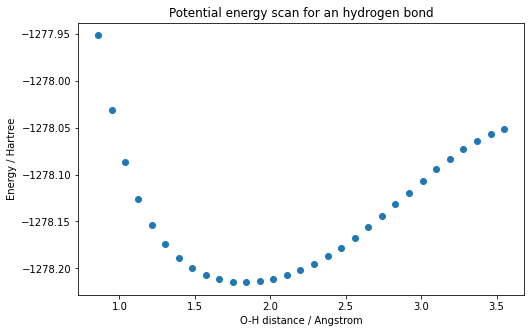

In [10]:
d = [3.550862922159438, 3.460762889964292, 3.370670305757595, 3.280585783157128, 3.1905100050249016, 3.1004437335081567, 3.0103878218778832, 2.9203432285513977, 2.8303110337833894, 2.740292459636501, 2.650288894007595, 2.5603019197028303, 2.4703333498422166, 2.3803852712588354, 2.29046009807724, 2.20056063836393, 2.1106901777200746, 2.020852585050676, 1.9310524476726847, 1.8412952456882081, 1.7515875795688893, 1.6619374708395822, 1.572354764687664, 1.4828516770284208, 1.3934435500122229, 1.3041499143311708, 1.214996013163829, 1.126015038057959, 1.0372514935327881, 0.9487664078760378, 0.8606456724847144]
e = [-1278.051959731282, -1278.057229408819, -1278.0643608792661, -1278.073141506658, -1278.0833167826524, -1278.0945967737384, -1278.1066656511987, -1278.119193003125, -1278.1316621874737, -1278.1441348500723, -1278.1561527375766, -1278.1674486239667, -1278.1778145272128, -1278.1870878716404, -1278.1951499219097, -1278.201919599394, -1278.2073419570033, -1278.2113710433855, -1278.2139489568763, -1278.214985604411, -1278.2143431181898, -1278.21182121378, -1278.2071290776098, -1278.19982995337, -1278.1892617407693, -1278.1744445322772, -1278.153955355375, -1278.1257011700952, -1278.086488264795, -1278.0312418159333, -1277.95164876962]
plt.figure(figsize=(8,5))
plt.title("Potential energy scan for an hydrogen bond")
plt.xlabel("O-H distance / Angstrom")
plt.ylabel("Energy / Hartree")
plt.scatter(d, e)

Discussion about the graph...

## 3. Closing words<a class="anchor" id="3"></a>

Great, so we see then that ONIOM has given us a lower ground state energy for our molecule than HF could have given us, although not quite as good as what we could have got from running MP2 on our system as a whole. Interestingly, this particular case is almost exactly half-way between the two. In this example, we have utilized different electronic structure solvers (MP2 and HF) to perform the ONIOM calculation. More generally, we note that one can use the same solver, with different basis choices (e.g. STO-3g and 6311++g**). The ONIOM method provides a great deal of flexibility in this manner. Looking forward, we intend to implement VQE as a solver in our ONIOM framework. 